In [13]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from pyHalo.preset_models import CDM
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import ft
from mejiro.utils import util
from mejiro.helpers import gs

Choose where to save

In [2]:
save_dir = os.path.join(array_dir, 'power_spectra')
util.create_directory_if_not_exists(save_dir)

Get lenses

In [3]:
num_lenses = 100

pickled_lens_list = os.path.join(config.machine.dir_01, '01_skypy_output_lens_list')
lens_list = util.unpickle(pickled_lens_list)[:num_lenses]

lens = lens_list[5]

Set parameters

In [4]:
# lens params
z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
# m_host = lens.get_main_halo_mass()
m_host = lens.lens_mass
log_m_host = np.log10(m_host)
r_tidal = 0.25
sigma_sub = 0.055
subhalo_cone = 6
los_normalization = 0

# imaging params
band = 'F184'
grid_oversample = 3
num_pix = 45
side = 4.95

Generate subhalos

In [5]:
cut_6 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            
            log_m_host=log_m_host, 
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

cut_7 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=7.,
            log_mhigh=10.,
            log_m_host=log_m_host, 
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

cut_8 = CDM(z_lens,
            z_source,
            sigma_sub=sigma_sub,
            log_mlow=8.,
            log_mhigh=10.,
            log_m_host=log_m_host, 
            r_tidal=r_tidal,
            cone_opening_angle_arcsec=subhalo_cone,
            LOS_normalization=los_normalization)

5 subhalos
1 subhalos
0 subhalos


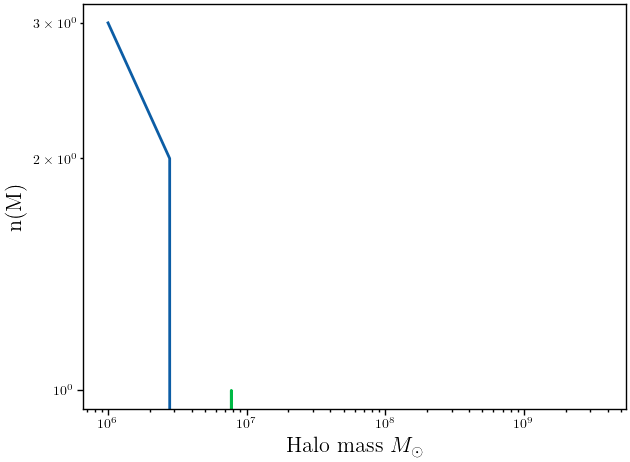

In [6]:
for realization in [cut_6, cut_7, cut_8]:
    halo_masses = [halo.mass for halo in realization.halos]
    print(f'{len(realization.halos)} subhalos')
    N, m = np.histogram(halo_masses, bins=np.logspace(6, 10, 10))
    plt.loglog(m[0:-1], N)
    
plt.xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
plt.ylabel('n(M)', fontsize=16)
plt.show()

Add subhalos to lenses

In [7]:
lens_cut_6 = deepcopy(lens)
lens_cut_7 = deepcopy(lens)
lens_cut_8 = deepcopy(lens)

lens_cut_6.add_subhalos(cut_6, suppress_output=False)
print('---------------------------------')
lens_cut_7.add_subhalos(cut_7, suppress_output=False)
print('---------------------------------')
lens_cut_8.add_subhalos(cut_8, suppress_output=False)

---------------------------------
---------------------------------


Generate lists

In [8]:
lenses = [lens, lens_cut_6, lens_cut_7, lens_cut_8]
titles = [f'lens_{lens.uid}_no_subhalos', f'lens_{lens.uid}_cut_6', f'lens_{lens.uid}_cut_7', f'lens_{lens.uid}_cut_8']

Generate all models

In [9]:
models = [lens.get_array(num_pix=num_pix * grid_oversample, side=side, band=band) for lens in lenses]

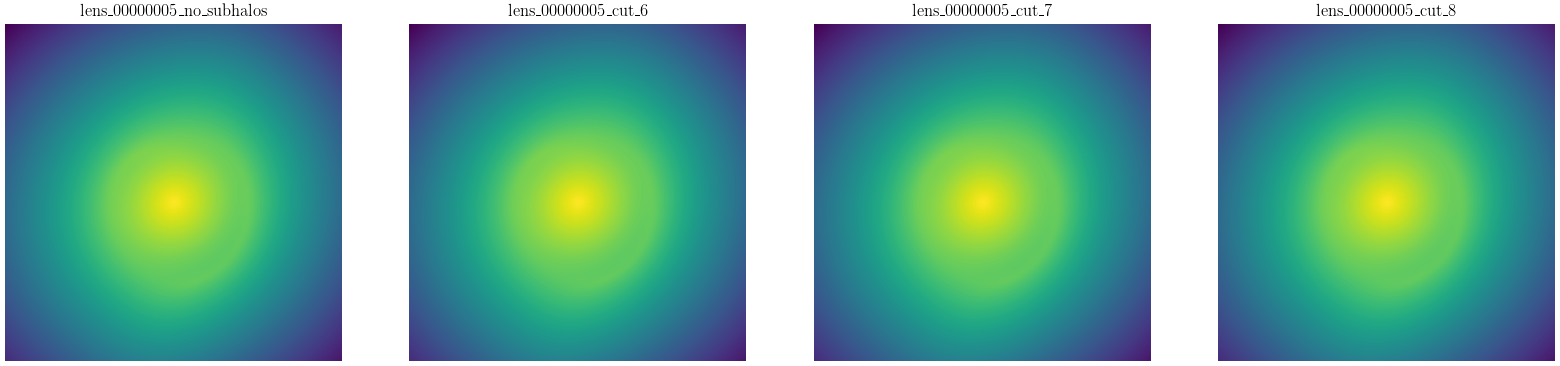

In [10]:
# quick check
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(np.log10(models[i]))
    ax.set_axis_off()
    ax.set_title(titles[i])

plt.show()

Generate all images

In [14]:
detector = gs.get_random_detector(suppress_output=False)
detector_pos = gs.get_random_detector_pos(num_pix, suppress_output=False)

images = []
power_spectra = []
for lens, model, title in tqdm(zip(lenses, models, titles), total=len(lenses)):
    gs_images, _ = gs.get_images(lens, model, band, input_size=num_pix, output_size=num_pix,
                                    grid_oversample=grid_oversample, psf_oversample=grid_oversample, 
                                    detector=detector, detector_pos=detector_pos, suppress_output=False)
    # np.save(os.path.join(save_dir, f'{title}.npy'), gs_images[0])
    images.append(gs_images[0])

    # generate power spectrum
    power_spectra.append(ft.power_spectrum(gs_images[0]))

Detector: 5
Detector position: 3665, 3860


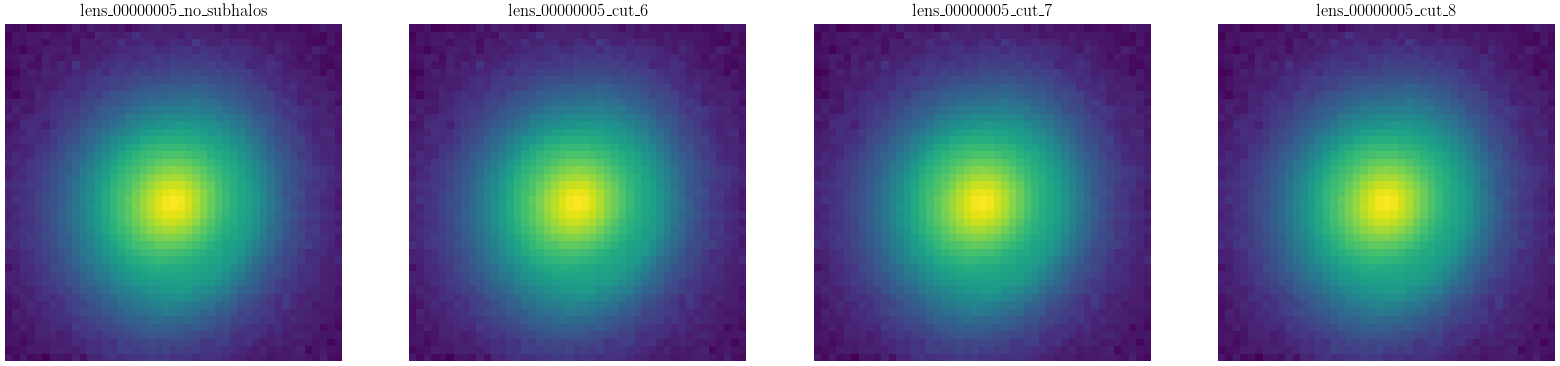

In [15]:
# quick check of images
fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(np.log10(images[i]))
    ax.set_axis_off()
    ax.set_title(titles[i])

plt.show()

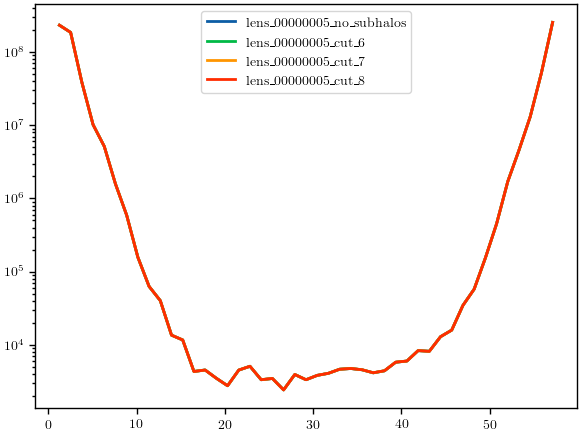

In [19]:
# quick check of power spectra
k_list = ft.get_k_list(0.11, side, num_pix)

for i, power_spectrum in enumerate(power_spectra):
    plt.plot(k_list, power_spectrum, label=titles[i])

plt.yscale('log')
plt.legend()
plt.show()

Generate convergence maps